In [20]:
from config import *
import os
from glob import glob
import sys
sys.path.append("..")

import numpy as np
import pickle

import matplotlib.pyplot as plt

from overall import load_file

In [42]:
exp_type = "adult"

if exp_type == "adult":
    checkpoint = "xgb-adult"
    noise_frac = 0.5
elif exp_type == "celeba":
    checkpoint = "resnet50"
    noise_frac = 1.0

# pos = glob(os.path.join(ckpt_dir, f"sup-wise/{checkpoint}-noise-{noise_frac:.2f}-support-*pkl"))

In [43]:
from utils import get_support_bucket

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, LeaveOneOut

from sklearn.metrics import accuracy_score, f1_score

In [36]:
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin

In [37]:
# with open("buckets.pkl", "rb") as f:
#     buckets = pickle.load(f)

from distill import Result
with open(f"{checkpoint}-results-v2.pkl", "rb") as f:
    results = pickle.load(f)

In [38]:
window = 5
sup_thresh = {
    "adult": 1.,
    "celeba": 0.5, # for celeba we do not take cases w/ support > 0.5 since only very few subgroups can be analyzed
}[exp_type]

buckets = { "pos": {}, "neg": []}
for r in results:
    if r.window != window or r.metric != "accuracy":
        continue
    bucket = r.support
    if r.gt == "pos":
        if r.support[0] > sup_thresh:
            continue # skip
        if bucket not in buckets["pos"]:
            buckets["pos"][bucket] = []
        buckets["pos"][bucket].append(np.vstack([r.delta, r.tstat]))
    elif r.gt == "neg":
        buckets["neg"].append(np.vstack([r.delta, r.tstat]))
buckets["pos"] = { k: np.stack(v) for k, v in buckets["pos"].items() }
buckets["neg"] = np.stack(buckets["neg"])
# buckets["pos"] = { r.support[0]: np.vstack([r.delta, r.tstat]) for r in results if r.gt == "pos" and r.window == window }
# buckets["neg"] = [ np.vstack([r.delta, r.tstat]) for r in results if r.gt == "neg" and r.window == window ]

In [39]:
if exp_type == "adult":
    with open("../summary_bucket_results_overall_adult.pkl", "rb") as f:
        summary = pickle.load(f)
elif exp_type == "celeba":
    with open("../summary_bucket_results_overall_celeba.pkl", "rb") as f:
        summary = pickle.load(f)

    # for celeba, we do not take cases w/ support > 0.5 since only very few subgroups can be analyzed
    # (adult has more subgroups with high support)
    for metric in ["accuracies", "precisions", "recalls", "f1s"]:
        for method in summary[metric]:
            summary[metric][method] = summary[metric][method][:-2] # hardcoded -2, removes supports > 0.5
    summary["supports"] = summary["supports"][:-2]

In [40]:

class Threshold(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold, gt=True):
        self.threshold = threshold
        self.gt = gt
    
    def fit(self, X, y):
        pass

    def predict(self, X):
        if self.gt:
            return (X > self.threshold).astype(int).flatten()
        else:
            return (X < self.threshold).astype(int).flatten()
    
    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

buckets_list = sorted(buckets["pos"].keys(), key=lambda x: x[0])
plotted = [False] * len(buckets_list)

plot_trees = False
plot_distrib = False

indicators = ["tstat", "delta"]

scores_acc = {}
scores_f1 = {}
raw_scores = {}

max_exp = 50

tau_t = 5
tau_delta = {"adult": -0.4, "celeba": -0.25 }[exp_type]

y_trues = { ind: [] for ind in indicators }
y_preds = { ind: [] for ind in indicators }

for indicator in indicators:
    if indicator == "tstat":
        # models = [ DecisionTreeClassifier(max_depth=1), LogisticRegression() ] + [ Threshold(i, gt=True) for i in [5] ]
        # model_names = [ "DT", "LR", r"$\tau > 5$" ]
        models = [ Threshold(i, gt=True) for i in [tau_t] ]
        model_names = [ fr"$\tau_t > {tau_t}$" ]
        # q = [100] # max
        func = np.max
    elif indicator == "delta":
        # models = [ DecisionTreeClassifier(max_depth=1), LogisticRegression() ] + [ Threshold(i, gt=False) for i in [-0.4 ]]
        # model_names = [ "DT", "LR", r"$\tau < -0.4$" ]
        models = [ Threshold(i, gt=False) for i in [tau_delta]]
        model_names = [fr"$\tau_\Delta < {tau_delta}$" ]
        # q = [0] # min
        func = np.min
    else:
        raise ValueError("Invalid indicator")
    
    scores_acc[indicator] = { model_name: [] for model_name in model_names }
    scores_f1[indicator] = { model_name: [] for model_name in model_names }
    raw_scores[indicator] = {}

    if plot_distrib:
        fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    ind_pos = 0 if indicator == "delta" else 1

    for model, model_name in zip(models, model_names):
        for bucket_pos, bucket in enumerate(buckets_list):
            X = np.vstack([
                # np.percentile(buckets["pos"][bucket][:, ind_pos], q, axis=1).T,
                # np.percentile(buckets["neg"][:len(buckets["pos"][bucket]), ind_pos], q, axis=1).T
                func(buckets["pos"][bucket][:max_exp, ind_pos], axis=1, where=buckets["pos"][bucket][:max_exp, ind_pos]<1e6, initial=0).reshape(-1,1),
                func(buckets["neg"][:len(buckets["pos"][bucket]), ind_pos], axis=1, where=buckets["neg"][:min(max_exp,len(buckets["pos"][bucket])), ind_pos]<1e6, initial=0).reshape(-1,1)
            ])
            # y = np.array([ 1 ] * len(buckets["pos"][bucket]) + [ 0 ] * len(buckets["neg"]))
            y = np.array([ 1 ] * min(max_exp, len(buckets["pos"][bucket])) + [ 0 ] * min(max_exp, len(buckets["pos"][bucket])))

            if not plotted[bucket_pos] and plot_distrib:
                plotted[bucket_pos] = True
                
                ax[bucket_pos // 4, bucket_pos % 4].hist(X[y==0, 0], bins=100, alpha=.5)
                ax[bucket_pos // 4, bucket_pos % 4].hist(X[y==1, 0], bins=100, alpha=.5)
                # ax[bucket_pos // 4, bucket_pos % 4].axvline(5, c='r', ls='--')

            # y_pred = cross_val_predict(model, X, y, cv=LeaveOneOut())
            y_pred = model.predict(X)

            y_trues[indicator].append(y)
            y_preds[indicator].append(y_pred)
            
            # y_pred = cross_val_predict(model, X, y, cv=10)
            scores_acc[indicator][model_name].append(accuracy_score(y, y_pred))
            scores_f1[indicator][model_name].append(f1_score(y, y_pred))
            raw_scores[indicator][bucket] = y, X[:, 0]


            if model_name == "DT" and plot_trees:
                model_full = model.fit(X, y)
                plt.figure()
                plot_tree(model_full)
                
            model_full = model.fit(X, y)

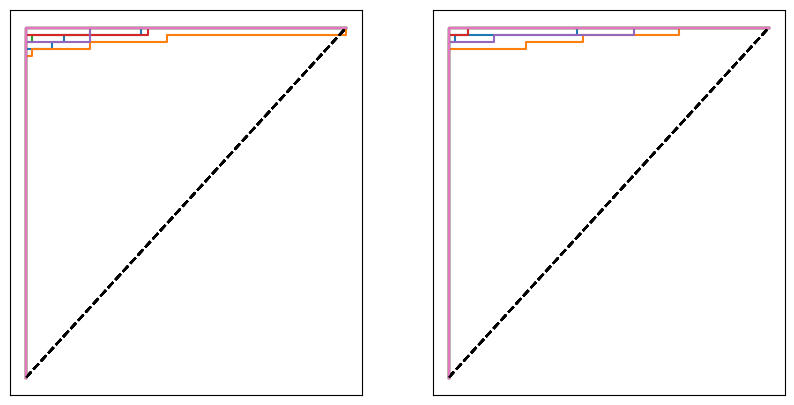

In [29]:
# fig, ax = plt.subplots(5, 5, figsize=(8, 8))
from sklearn.metrics import roc_auc_score

fig, ax = plt.subplots(1, 2, figsize=(10,5))

# roc curves
from sklearn.metrics import roc_curve

aucs = {}
best_thresh = {}
for i, indicator in enumerate(indicators):
    aucs[indicator] = []
    best_thresh[indicator] = []
    for bucket_pos, bucket in enumerate(buckets_list):
        y, X = raw_scores[indicator][bucket]
        if indicator == "delta":
            X = -X
        fpr, tpr, thresh = roc_curve(y, X)
        auc = roc_auc_score(y, X)
        aucs[indicator].append(auc)
        

        j_statistic = tpr - fpr
        optimal_threshold_index = np.argmax(j_statistic)
        # [bucket_pos // 4, bucket_pos % 4]
        ax[i].plot(fpr, tpr)
        ax[i].plot([0, 1], [0, 1], c='k', ls='--')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        best_thresh[indicator].append(thresh[optimal_threshold_index])

with open(f"best_thresh_{exp_type}.pkl", "wb") as f:
    pickle.dump((best_thresh, buckets_list), f)

ValueError: x and y must have same first dimension, but have shapes (19,) and (17,)

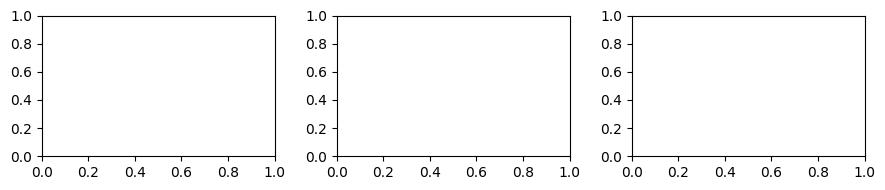

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(9,2))
# tight layout
plt.tight_layout()

ax[0].plot([ b[0] for b in buckets_list ], aucs["delta"], label=rf"$\Delta < {tau_delta}$", marker='d', c='tab:green')
ax[0].plot([ b[0] for b in buckets_list ], aucs["tstat"], label=rf"$t > {tau_t}$", marker='o', c='tab:red')
ax[0].set_ylabel("AUC")

ax[1].axhline(tau_t, c='r', ls='--', label=rf"$\tau_{{t}} = {tau_t}$")
ax[2].axhline(tau_delta, c='r', ls='--', label=rf"$\tau_{{\Delta}} = {tau_delta}$")
ax[1].plot([ b[0] for b in buckets_list ], best_thresh["tstat"], c='b')
ax[2].plot([ b[0] for b in buckets_list ], [ -d for d in best_thresh["delta"]], c='b')

ax[1].set_ylabel(r"$\tau_{t}$")
ax[2].set_ylabel(r"$\tau_{\Delta}$")

# rotate y labels
for i in range(1,3):
    ax[i].tick_params(axis='y', rotation=90)

for i in range(3):
    ax[i].grid()
    ax[i].set_xscale("log")
    ax[i].set_xlabel("Support")
    ax[i].legend()

fig.savefig(f"tuning-tau-{exp_type}.pdf", bbox_inches='tight')

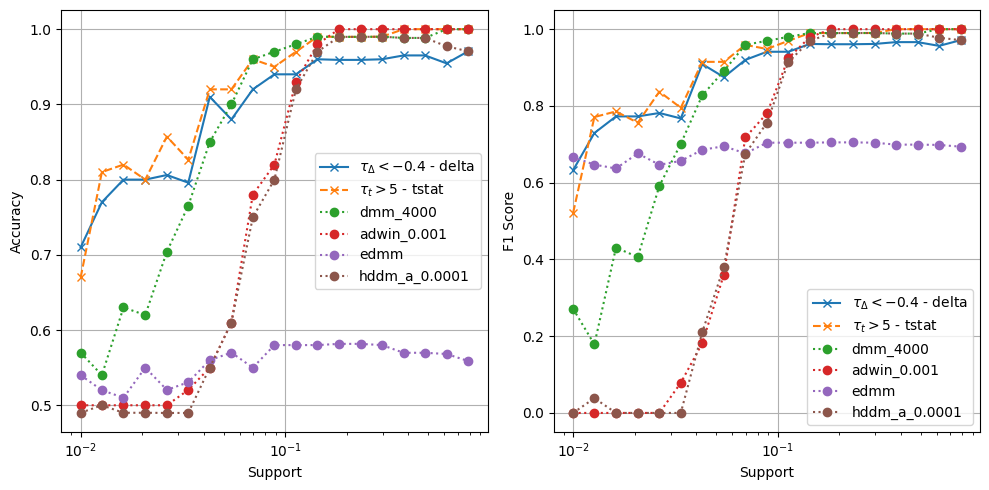

In [44]:
# 2 plots, with extra space for the legend 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for k, v in scores_acc["delta"].items():
    ax[0].plot([ b[0] for b in buckets_list ], v, label=f"{k} - delta", marker='x')
    
for k, v in scores_f1["delta"].items():
    ax[1].plot([ b[0] for b in buckets_list ], v, label=f"{k} - delta", marker='x')

for k, v in scores_acc["tstat"].items():
    ax[0].plot([ b[0] for b in buckets_list ], v, label=f"{k} - tstat", marker='x', ls='--')
    
for k, v in scores_f1["tstat"].items():
    ax[1].plot([ b[0] for b in buckets_list ], v, label=f"{k} - tstat", marker='x', ls='--')


models = summary["accuracies"].keys()

for model in models:
    ax[0].plot([ s[0] for s in summary["supports"]], summary["accuracies"][model], label=model, ls=':', marker='o')
    ax[1].plot([ s[0] for s in summary["supports"]], summary["f1s"][model], label=model, ls=':', marker='o')
# ax[0].legend()
ax[0].set_xlabel("Support")
ax[0].set_ylabel("Accuracy")
ax[0].grid()

# ax[1].legend()
ax[1].set_xlabel("Support")
ax[1].set_ylabel("F1 Score")
ax[1].grid()

ax[0].set_xscale("log")
ax[1].set_xscale("log")

plt.tight_layout()
# show legend of figure
ax[0].legend()
ax[1].legend()



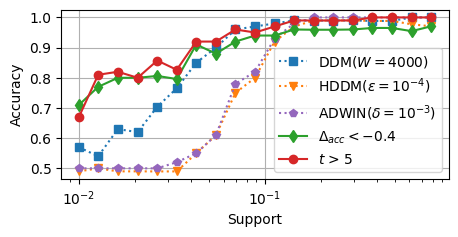

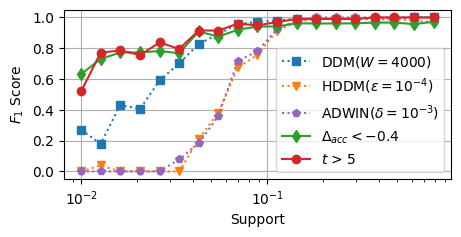

In [45]:
# 2 plots, with extra space for the legend 
# fig, ax = plt.subplots(2,1, figsize=(4.5,5.))
# plt.tight_layout()
fig0, ax0 = plt.subplots(figsize=(5, 2.2))
fig1, ax1 = plt.subplots(figsize=(5, 2.2))

models = summary["accuracies"].keys()
markers = ['d', 'o', 's', 'v', 'p', '^', '<', '>', 'p', 'h']
colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# for i, (model, legend) in enumerate([("dmm_4000", "DMM($W=4000$)"), ("adwin_0.004", "ADWIN($\delta=0.004$)")]):
for i, (model, legend) in enumerate([("dmm_4000", "DDM($W=4000$)"), ("hddm_a_0.0001", "HDDM($\epsilon=10^{-4}$)"), ("adwin_0.001", "ADWIN($\delta=10^{-3}$)")]):
    ax0.plot([ s[0] for s in summary["supports"]], summary["accuracies"][model], label=legend, ls=':', marker=markers[2+i], color=colors[i+2])
    ax1.plot([ s[0] for s in summary["supports"]], summary["f1s"][model], label=legend, ls=':', marker=markers[2+i], color=colors[i+2])

ax0.plot([ b[0] for b in buckets_list ], scores_acc["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=rf"$\Delta_{{acc}} < {tau_delta}$", marker=markers[0], color=colors[0])
ax1.plot([ b[0] for b in buckets_list ], scores_f1["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=rf"$\Delta_{{acc}} < {tau_delta}$", marker=markers[0], color=colors[0])
ax0.plot([ b[0] for b in buckets_list ], scores_acc["tstat"][rf'$\tau_t > {tau_t}$'], label=fr"$t$ > {tau_t}", marker=markers[1], color=colors[1])
ax1.plot([ b[0] for b in buckets_list ], scores_f1["tstat"][rf'$\tau_t > {tau_t}$'], label=fr"$t$ > {tau_t}", marker=markers[1], color=colors[1])
    


# ax[0].legend()
ax0.set_xlabel("Support")
ax0.set_ylabel("Accuracy")
ax0.grid()

# ax[1].legend()
ax1.set_xlabel("Support")
ax1.set_ylabel("$F_1$ Score")
ax1.grid()

ax0.set_xscale("log")
ax1.set_xscale("log")

# show legend of figure
ax0.legend()
ax1.legend()

fig0.savefig(f"overall-detection-acc-{exp_type}.pdf", bbox_inches='tight')
fig1.savefig(f"overall-detection-f1-{exp_type}.pdf", bbox_inches='tight')

In [46]:
import pandas as pd

dataset_name = {"adult": "Adult", "celeba": "CelebA"}[exp_type]

acc_delta = accuracy_score(np.hstack(y_trues["delta"]), np.hstack(y_preds["delta"]))
acc_tstat = accuracy_score(np.hstack(y_trues["tstat"]), np.hstack(y_preds["tstat"]))
f1_delta = f1_score(np.hstack(y_trues["delta"]), np.hstack(y_preds["delta"]))
f1_tstat = f1_score(np.hstack(y_trues["tstat"]), np.hstack(y_preds["tstat"]))

data = {
    dataset_name: {
        ("Accuracy", rf"\textsc{{DriftExplorer}} w/ $\Delta_{{perf}}$"): f"{acc_delta:.4f}",
        ("Accuracy", fr"\textsc{{DriftExplorer}} w/ $t$"): f"{acc_tstat:.4f}",
        ("F1 Score", rf"\textsc{{DriftExplorer}} w/ $\Delta_{{perf}}$"): f"{f1_delta:.4f}",
        ("F1 Score", fr"\textsc{{DriftExplorer}} w/ $t$"): f"{f1_tstat:.4f}",
    }
}

with open(f"../true_y_pred_results_overall_{exp_type}.pkl", "rb") as f:
    obj = pickle.load(f)

for method, method_name in zip(["dmm_4000", "hddm_a_0.0001", "adwin_0.001"], ["DMM($W=4000$)", "HDDM($\epsilon=10^{-4}$)", "ADWIN($\delta=10^{-3}$)"]):
    obj_results = { k: v for k, v in obj[method].items() if k[0] < sup_thresh }
    y_trues_method = np.hstack([ np.array(v["y_true"]) for v in obj_results.values() ])
    y_preds_method = np.hstack([ np.array(v["y_pred_raw"])>=1 for v in obj_results.values() ]) # >= 1 since the ROC curve shows this to be the best value

    acc = accuracy_score(y_trues_method, y_preds_method)
    f1 = f1_score(y_trues_method, y_preds_method)
    data[dataset_name][("Accuracy", f"{method_name}")] = f"{acc:.4f}"
    data[dataset_name][("F1 Score", f"{method_name}")] = f"{f1:.4f}"

print(pd.DataFrame(data).to_latex())

\begin{tabular}{lll}
\toprule
 &  & Adult \\
\midrule
\multirow[t]{5}{*}{Accuracy} & ADWIN($\delta=10^{-3}$) & 0.7537 \\
 & DMM($W=4000$) & 0.8530 \\
 & HDDM($\epsilon=10^{-4}$) & 0.7417 \\
 & \textsc{DriftExplorer} w/ $\Delta_{perf}$ & 0.8869 \\
 & \textsc{DriftExplorer} w/ $t$ & 0.9122 \\
\cline{1-3}
\multirow[t]{5}{*}{F1 Score} & ADWIN($\delta=10^{-3}$) & 0.6733 \\
 & DMM($W=4000$) & 0.8316 \\
 & HDDM($\epsilon=10^{-4}$) & 0.6617 \\
 & \textsc{DriftExplorer} w/ $\Delta_{perf}$ & 0.8829 \\
 & \textsc{DriftExplorer} w/ $t$ & 0.9055 \\
\cline{1-3}
\bottomrule
\end{tabular}



In [26]:
method

'adwin_0.001'

In [30]:
obj_results.keys()

dict_keys([(0.01, 0.0127), (0.0127, 0.0162), (0.0162, 0.0207), (0.0207, 0.0264), (0.0264, 0.0336), (0.0336, 0.0428), (0.0428, 0.0546), (0.0546, 0.0695), (0.0695, 0.0886), (0.0886, 0.1129), (0.1129, 0.1438), (0.1438, 0.1833), (0.1833, 0.2336), (0.2336, 0.2976), (0.2976, 0.3793), (0.3793, 0.4833), (0.4833, 0.6158)])

In [25]:
obj["dmm_4000"].keys()

dict_keys([(0.01, 0.0127), (0.0127, 0.0162), (0.0162, 0.0207), (0.0207, 0.0264), (0.0264, 0.0336), (0.0336, 0.0428), (0.0428, 0.0546), (0.0546, 0.0695), (0.0695, 0.0886), (0.0886, 0.1129), (0.1129, 0.1438), (0.1438, 0.1833), (0.1833, 0.2336), (0.2336, 0.2976), (0.2976, 0.3793), (0.3793, 0.4833), (0.4833, 0.6158), (0.6158, 0.7848), (0.7848, 1.0)])

In [24]:
3

3

(0.01, 0.0127) => 1
(0.0127, 0.0162) => 1
(0.0162, 0.0207) => 1
(0.0207, 0.0264) => 1
(0.0264, 0.0336) => 1
(0.0336, 0.0428) => 1
(0.0428, 0.0546) => 1
(0.0546, 0.0695) => 1
(0.0695, 0.0886) => 1
(0.0886, 0.1129) => 1
(0.1129, 0.1438) => 1
(0.1438, 0.1833) => 1
(0.1833, 0.2336) => 2
(0.2336, 0.2976) => 4
(0.2976, 0.3793) => 2
(0.3793, 0.4833) => 3
(0.4833, 0.6158) => 6
(0.6158, 0.7848) => 6
(0.7848, 1.0) => 8


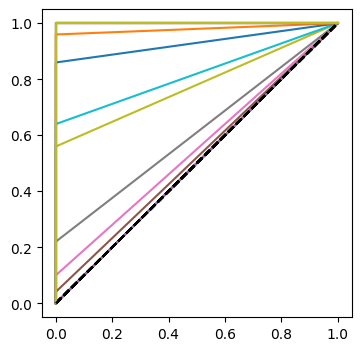

In [72]:
method = "adwin_0.001"
raw_scores_oth = { k: (v["y_true"], v["y_pred_raw"]) for k, v in obj[method].items() }
from sklearn.metrics import roc_auc_score
fig, ax = plt.subplots(figsize=(4,4))
# roc curves
from sklearn.metrics import roc_curve

aucs = {}
best_thresh = {}
aucs = []
best_thresh = []
buckets_list = sorted(raw_scores_oth.keys(), key=lambda x: x[0])
for bucket_pos, bucket in enumerate(buckets_list):
    y, X = raw_scores_oth[bucket]

    fpr, tpr, thresh = roc_curve(y, X)
    auc = roc_auc_score(y, X)
    aucs.append(auc)
    
    j_statistic = tpr - fpr
    optimal_threshold_index = np.argmax(j_statistic)
    # [bucket_pos // 4, bucket_pos % 4]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], c='k', ls='--')
    # ax.set_xticks([])
    # ax.set_yticks([])
    best_thresh.append(thresh[optimal_threshold_index])
    print(bucket, "=>", thresh[optimal_threshold_index])

In [1]:
import pandas as pd

In [19]:
import glob
import pickle

with open(glob.glob("../../models-ckpt/sup-wise/*.pkl")[0], "rb") as f:
    obj = pickle.load(f)

In [20]:
obj['matches_batches'][0]

Matches(matches=<3377x26597 sparse array of type '<class 'numpy.bool_'>'
	with 2168714 stored elements in Compressed Sparse Row format>, fi=        support         itemsets
0      0.835341             (23)
1      0.415637             (19)
2      0.203968              (2)
3      0.042231             (16)
4      0.772902             (38)
...         ...              ...
26592  0.010128       (5, 21, 6)
26593  0.010109   (5, 19, 21, 6)
26594  0.014482     (19, 20, 21)
26595  0.011352      (20, 21, 6)
26596  0.011333  (19, 20, 21, 6)

[26597 rows x 2 columns])

In [17]:
# load celeba
from torchvision.datasets import CelebA

ds = CelebA(root="../../data", split="all", target_type="identity", download=False)

In [18]:
len(ds)

202599

In [29]:
ds.attr[:,2].float().mean()

tensor(0.5125)

In [26]:

data = {
    "Adult": {
        "Samples": 48842,
        "Type": "Tabular",
        "Descriptive features": 14,
        "Feature type": "categorical, continuous (binned)",
        "# Subgroups (minsup = 0.01)": 192099,
        "Binary target": r"Income $\ge$ 50K? y/n",
    },
    "CelebA": {
        "Samples": 202599,
        "Type": "Images + annotations",
        "Descriptive features": 39,
        "Feature type": "binary",
        "# Subgroups (minsup = 0.01)": 26597,
        "Binary target": "Attractive? y/n"
    }
}

df = pd.DataFrame(data)
print(df.to_latex())

\begin{tabular}{lll}
\toprule
 & Adult & CelebA \\
\midrule
Samples & 48842 & 202599 \\
Type & Tabular & Images + annotations \\
Descriptive features & 14 & 39 \\
Feature type & categorical, continuous (binned) & binary \\
# Subgroups (minsup = 0.01) & 192099 & 26597 \\
Binary target & Income $\ge$ 50K? y/n & Attractive? y/n \\
\bottomrule
\end{tabular}



In [31]:
    
def load_adult_df():
    columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","target"]
    categ = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]
    num = [ c for c in columns if c not in categ and c != "target" ]
    df = pd.concat([pd.read_csv(os.path.join(data_dir, "adult.data"), header=None, index_col=False), pd.read_csv(os.path.join(data_dir, "adult.test"), header=None, index_col=False, skiprows=1)], axis=0)
    df.columns = columns
    df["target"] = df["target"].apply(lambda x: 1 if x in [" >50K", ">50K."] else 0)
    return df, categ, num

df = load_adult_df()

In [34]:
df, categ, num = load_adult_df()

In [36]:
df.target.mean()

0.16053806150444289

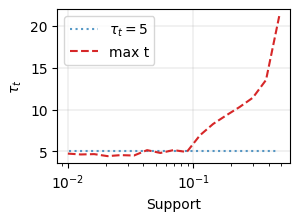

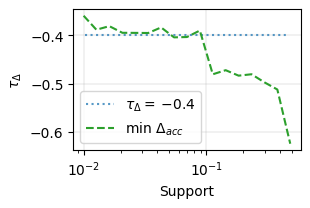

In [19]:
fig0, ax0 = plt.subplots(figsize=(3, 2))
fig1, ax1 = plt.subplots(figsize=(3, 2))
# tight layout
plt.tight_layout()

tau_t = 5

ax0.axhline(tau_t, 0.05, 0.95, c='tab:blue', alpha=.75, ls=':', label=rf"$\tau_{{t}} = 5$")
ax1.axhline(-0.4,  0.05, 0.95, c='tab:blue',  alpha=.75,ls=':', label=rf"$\tau_{{\Delta}} = -\!0.4$")
# ax1.axhline(-0.25, 0.05, 0.95, c='tab:blue', alpha=.75, ls='--', label=rf"$\tau_{{\Delta,C}} = -\!0.25$")

with open("best_thresh_adult.pkl", "rb") as f:
    best_thresh_adult, buckets_list_adult = pickle.load(f)
with open("best_thresh_celeba.pkl", "rb") as f:
    best_thresh_celeba, buckets_list_celeba = pickle.load(f)

ax0.plot([ b[0] for b in buckets_list_adult ][:-2], best_thresh_adult["tstat"][:-2], c='tab:red', ls ='--',label="max t")
# ax0.plot([ b[0] for b in buckets_list_celeba ], best_thresh_celeba["tstat"], c='tab:red',ls ='--', label="CelebA")

ax1.plot([ b[0] for b in buckets_list_adult ][:-2], [ -d for d in best_thresh_adult["delta"]][:-2], c='tab:green',ls ='--',label="min $\Delta_{acc}$")
# ax1.plot([ b[0] for b in buckets_list_celeba ], [ -d for d in best_thresh_celeba["delta"]], c='tab:green',ls ='--', label="CelebA")

ax0.set_ylabel(r"$\tau_{t}$")
ax1.set_ylabel(r"$\tau_{\Delta}$")

# rotate y labels
# for ax in [ax0, ax1]:
#     ax.tick_params(axis='y', rotation=90)

for ax in [ax0, ax1]:
    ax.grid(linewidth=.25)
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Support")

# ax0.set_ylim([0, 75])
# ax0.set_yticks([10, 30, 50, 70])

fig0.savefig(f"tau-t-vs-sup.pdf", bbox_inches='tight')
fig1.savefig(f"tau-delta-vs-sup.pdf", bbox_inches='tight')